## 0. Modules and Functions

### Functions
- parse_add(addtional_part_of_gencode)
- sam_to_table(sam_file_code)
- read_specific_transcript(sam_file_code, transcript)
- read_from_trx_ser(sam_file_code, filtered_trx_series)

In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def parse_add(add):
    ret_dict = {'transcript_id':'NaN'}
    valid = ['gene_id','transcript_id','gene_type','gene_name','level']
    for row in add.split(';'):
        kv_pair = row.split()
        if len(kv_pair)<=1 : continue
        if kv_pair[0] in valid:
            ret_dict[kv_pair[0]]=kv_pair[1]
    return [val.replace('"','') for val in ret_dict.values()]

In [5]:
def sam_to_table(code):
    read_table = defaultdict(int)
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
        
            line_list = line.split()
            if line_list[1]==4 or line_list[1]==16: continue # 잘못 read된 data 제거
        
            if line_list[2].startswith('ENSMUST'):
                read_table[line_list[2].split('|')[0]]+=1
            
    table_df = pd.Series(read_table)
    return table_df[table_df>= 30] # 30 read 보다 작은 경우는 filter

In [6]:
def read_specific_transcript(code, trans):
    read_table = defaultdict(int)
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
            
            line_list = line.split()
            if line_list[1]==4: continue # 잘못 read된 data 제거
        
            if line_list[2].startswith(trans):
                read_table[int(line_list[3])]+=1
            
    table_df = pd.Series(read_table)
    return table_df

In [7]:
def read_from_trx_ser(code, trx_ser_idx):
    read_table = []
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
            
            line_list = line.split()
            if line_list[1]==4: continue # 잘못 read된 data 제거
        
            if line_list[2].startswith('ENSMUST'):
                if line_list[2].split('|')[0] in trx_ser_idx:
                    read_table.append([line_list[2].split('|')[0], int(line_list[3]), 1])
            
    table_df = pd.DataFrame(read_table)
    table_df.columns = ['trx', 'pos', 'cnt']
    return table_df

## 1.GTF File Parsing

### Informations we need
- column 3 : feature type
- column 4 : genomic start loc
- column 5 : genomic end loc
- column 7 : genomic strand(+/-)
- column 9 : additional info
    - gene_id
    - transcript_id
    - gene_type
    - level
    
### Filtering
- non coding genes
- gene level not 1
- (+) strand

In [8]:
path = "/home/qbio1/kangjunseo/tutorials/ref_gene/gencode.vM29.primary_assembly.annotation.gtf"

In [9]:
GTF_df = pd.read_csv(path, header=5, delimiter='\t')
GTF_df.columns=['chr','ann','feature','start','end','score','strand','phase','add']
GTF_df.head()

,chr,ann,feature,start,end,score,strand,phase,add
0,chr1,HAVANA,transcript,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
1,chr1,HAVANA,exon,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
2,chr1,ENSEMBL,gene,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; gene_type ""snR..."
3,chr1,ENSEMBL,transcript,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."
4,chr1,ENSEMBL,exon,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."


In [10]:
GTF_df_compact = GTF_df.drop(columns=['chr','ann','score','phase'])
GTF_df_compact.head()

,feature,start,end,strand,add
0,transcript,3143476,3144545,+,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
1,exon,3143476,3144545,+,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
2,gene,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; gene_type ""snR..."
3,transcript,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."
4,exon,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."


In [11]:
add_table = []
for row in GTF_df['add']:
    add_table.append(parse_add(row))
add_df = pd.DataFrame(add_table)
add_df.head()

,0,1,2,3,4
0,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
1,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
2,NaN,ENSMUSG00000064842.3,snRNA,Gm26206,3
3,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3
4,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3


In [12]:
GTF_df2_untrimmed = pd.concat([GTF_df_compact,add_df], axis=1)
GTF_df2_untrimmed = GTF_df2_untrimmed.drop(columns=['add'])
GTF_df2_untrimmed.columns = ['feature','start','end','strand','transcript_id','gene_id','gene_type','gene_name','level']
GTF_df2_untrimmed.head()

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level
0,transcript,3143476,3144545,+,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
1,exon,3143476,3144545,+,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
2,gene,3172239,3172348,+,NaN,ENSMUSG00000064842.3,snRNA,Gm26206,3
3,transcript,3172239,3172348,+,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3
4,exon,3172239,3172348,+,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3


In [13]:
GTF_df2 = GTF_df2_untrimmed[GTF_df2_untrimmed['gene_type']=='protein_coding']
#GTF_df2 = GTF_df2[(GTF_df2['level']=='1')|(GTF_df2['level']=='2')]
GTF_df2['length'] = GTF_df2['end']-GTF_df2['start']+1

/tmp/ipykernel_853130/3454634102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GTF_df2['length'] = GTF_df2['end']-GTF_df2['start']+1


In [14]:
GTF_df2_plus = GTF_df2[GTF_df2['strand']=='+']
GTF_df2_plus.head(30)

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level,length
354,gene,4878011,4918633,+,NaN,ENSMUSG00000025903.15,protein_coding,Lypla1,2,40623
355,transcript,4878011,4918633,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,40623
356,exon,4878011,4878205,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,195
357,CDS,4878137,4878205,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,69
358,start_codon,4878137,4878139,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,3
359,exon,4878678,4878709,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,32
360,CDS,4878678,4878709,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,32
361,exon,4898807,4898872,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,66
362,CDS,4898807,4898872,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,66
363,exon,4900491,4900538,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,48


In [15]:
GTF_df2_plus_CDS = GTF_df2_plus[GTF_df2_plus['feature']=='CDS']
GTF_df2_plus_CDS.head()

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level,length
357,CDS,4878137,4878205,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,69
360,CDS,4878678,4878709,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,32
362,CDS,4898807,4898872,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,66
364,CDS,4900491,4900538,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,48
366,CDS,4902534,4902604,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,71


In [31]:
trx_ser = GTF_df2_plus_CDS[['transcript_id','length','gene_id']].groupby(by=['transcript_id','gene_id']).sum().sort_values(by=['length'], ascending=False)
trx_ser

,,length
transcript_id,gene_id,
ENSMUST00000183034.5,ENSMUSG00000026131.21,23151
ENSMUST00000239545.1,ENSMUSG00000118670.1,22572
ENSMUST00000115104.10,ENSMUSG00000026131.21,22218
ENSMUST00000097785.10,ENSMUSG00000026131.21,22179
ENSMUST00000143764.9,ENSMUSG00000075249.13,20985
...,...,...
ENSMUST00000202527.4,ENSMUSG00000023033.15,3
ENSMUST00000202071.2,ENSMUSG00000023033.15,3
ENSMUST00000200933.4,ENSMUSG00000023033.15,3


## 2. Figure S5A (1 gene)

In [17]:
table = sam_to_table("RPF_siLin28a").sort_values(ascending=False)
table.head()

ENSMUST00000240377.1     1007005
ENSMUST00000082402.1       13957
ENSMUST00000027752.15      12497
ENSMUST00000055226.13       8926
ENSMUST00000020238.14       8925
dtype: int64

In [280]:
table2 = sam_to_table("RPF_siLuc").sort_values(ascending=False)
table2.head()

ENSMUST00000240377.1     6432837
ENSMUST00000082402.1       63193
ENSMUST00000024739.14      62942
ENSMUST00000094361.11      61914
ENSMUST00000021698.13      59815
dtype: int64

<AxesSubplot:>

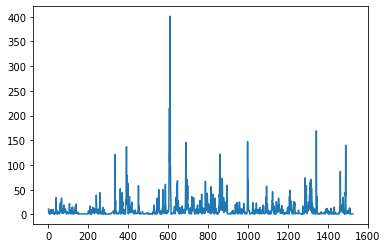

In [273]:
RST = read_specific_transcript("RPF_siLin28a","ENSMUST00000082402.1").sort_index()
RST.plot()

<AxesSubplot:>

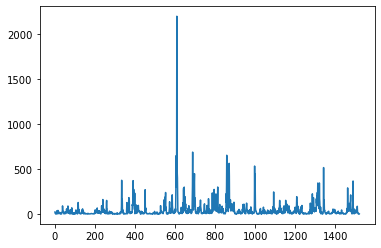

In [281]:
RST = read_specific_transcript("RPF_siLuc","ENSMUST00000082402.1").sort_index()
RST.plot()

In [285]:
one_gene_df = GTF_df2_untrimmed[GTF_df2_untrimmed['transcript_id']=="ENSMUST00000082402.1"]
one_gene_df.head()

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level
1869389,transcript,5328,6872,+,ENSMUST00000082402.1,ENSMUSG00000064351.1,protein_coding,mt-Co1,3
1869390,exon,5328,6872,+,ENSMUST00000082402.1,ENSMUSG00000064351.1,protein_coding,mt-Co1,3
1869391,CDS,5328,6869,+,ENSMUST00000082402.1,ENSMUSG00000064351.1,protein_coding,mt-Co1,3
1869392,start_codon,5328,5330,+,ENSMUST00000082402.1,ENSMUSG00000064351.1,protein_coding,mt-Co1,3
1869393,stop_codon,6870,6872,+,ENSMUST00000082402.1,ENSMUSG00000064351.1,protein_coding,mt-Co1,3


(0.0, 100.0)

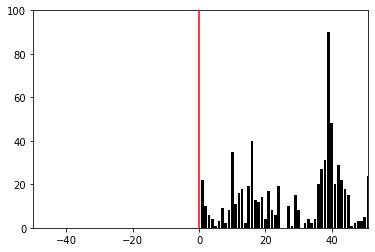

In [293]:
plt.bar(RST.index, RST.values, color='k', zorder=10)
plt.axvline(0, color='r', zorder=5)
plt.xlim(-50,51)
plt.ylim(0,100)

(0.0, 100.0)

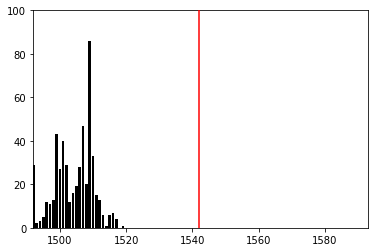

In [294]:
end = 6869-5328+1
plt.bar(RST.index, RST.values, color='k', zorder=10)
plt.axvline(end, color='r', zorder=5)
plt.xlim(end-50, end+51)
plt.ylim(0,100)

## 3. Figure S5A (coding genes)

In [42]:
trx_ser['gene'] = [g for t, g in trx_ser.index]
trx_ser.index = [t for t,g in trx_ser.index]
trx_ser

,length,gene
ENSMUST00000183034.5,23151,ENSMUSG00000026131.21
ENSMUST00000239545.1,22572,ENSMUSG00000118670.1
ENSMUST00000115104.10,22218,ENSMUSG00000026131.21
ENSMUST00000097785.10,22179,ENSMUSG00000026131.21
ENSMUST00000143764.9,20985,ENSMUSG00000075249.13
...,...,...
ENSMUST00000202527.4,3,ENSMUSG00000023033.15
ENSMUST00000202071.2,3,ENSMUSG00000023033.15
ENSMUST00000200933.4,3,ENSMUSG00000023033.15
ENSMUST00000201484.4,3,ENSMUSG00000023033.15


In [44]:
trx_ser_best = trx_ser.drop_duplicates('gene') # longest isoform만 남기기
trx_ser_best

,length,gene
ENSMUST00000183034.5,23151,ENSMUSG00000026131.21
ENSMUST00000239545.1,22572,ENSMUSG00000118670.1
ENSMUST00000143764.9,20985,ENSMUSG00000075249.13
ENSMUST00000044217.16,20622,ENSMUSG00000063450.15
ENSMUST00000212287.2,17424,ENSMUSG00000040838.11
...,...,...
ENSMUST00000166681.2,48,ENSMUSG00000092004.2
ENSMUST00000168858.2,45,ENSMUSG00000079333.4
ENSMUST00000165358.2,45,ENSMUSG00000091109.2
ENSMUST00000179793.2,24,ENSMUSG00000095386.2


In [45]:
CDS_read = read_from_trx_ser("RPF_siLin28a", trx_ser_best.index)
CDS_read.head()

,trx,pos,cnt
0,ENSMUST00000116560.3,317,1
1,ENSMUST00000077271.9,1382,1
2,ENSMUST00000190686.7,1105,1
3,ENSMUST00000046404.8,455,1
4,ENSMUST00000105105.4,37,1


In [20]:
utrs = GTF_df2[GTF_df2['feature']=='UTR']
utr_map = utrs[['transcript_id','start','end']].groupby(by=['transcript_id']).min()
utr_map['length'] = utr_map['end'] - utr_map['start'] + 1
utr_map.sort_values(by=['length'], ascending=False)

,start,end,length
transcript_id,,,
ENSMUST00000053033.14,97534043,97573442,39400
ENSMUST00000233317.2,85851232,85874416,23185
ENSMUST00000232701.2,12296778,12316373,19596
ENSMUST00000053880.13,135690231,135709098,18868
ENSMUST00000233892.2,12296778,12315399,18622
...,...,...,...
ENSMUST00000128420.9,46451264,46451264,1
ENSMUST00000212277.2,70388686,70388686,1
ENSMUST00000198126.2,138148942,138148942,1


In [46]:
CDS_np = CDS_read.to_numpy()
for row in CDS_np:
    try:
        row[1] -= utr_map['length'][row[0]]
    except:
        pass
CDS_np

array([['ENSMUST00000116560.3', 202, 1],
       ['ENSMUST00000077271.9', 1239, 1],
       ['ENSMUST00000190686.7', 893, 1],
       ...,
       ['ENSMUST00000082402.1', 61, 1],
       ['ENSMUST00000056449.9', 800, 1],
       ['ENSMUST00000171332.2', 12744, 1]], dtype=object)

In [47]:
CDS_read_start = pd.DataFrame(CDS_np)
CDS_read_start.columns = ['trx','pos','cnt']
read_count = CDS_read_start[['pos','cnt']].groupby(by=['pos']).sum()
read_count.head()

,cnt
pos,
-7163,1
-7162,1
-7135,1
-7111,1
-7047,1


(0.0, 12000.0)

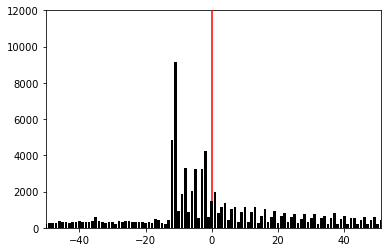

In [54]:
plt.bar(list(map(int, read_count.index)), list(map(int, read_count.values)), color='k', zorder=10)
plt.axvline(0, color='r', zorder=5)
plt.xlim(-50,51)
plt.ylim(0,12000)

In [49]:
CDS_np2 = CDS_read.to_numpy()
for row in CDS_np2:
    row[1] -= trx_ser_best['length'][row[0]]
    try:
        row[1] -= utr_map['length'][row[0]]
    except:
        pass
CDS_np2

array([['ENSMUST00000116560.3', -479, 1],
       ['ENSMUST00000077271.9', -1014, 1],
       ['ENSMUST00000190686.7', -7216, 1],
       ...,
       ['ENSMUST00000082402.1', -1481, 1],
       ['ENSMUST00000056449.9', -2479, 1],
       ['ENSMUST00000171332.2', -405, 1]], dtype=object)

In [50]:
CDS_read_end = pd.DataFrame(CDS_np2)
CDS_read_end.columns = ['trx','pos','cnt']
read_count2 = CDS_read_end[['pos','cnt']].groupby(by=['pos']).sum()
read_count2.head()

,cnt
pos,
-23054,1
-23045,1
-22904,1
-22655,1
-22574,1


(0.0, 12000.0)

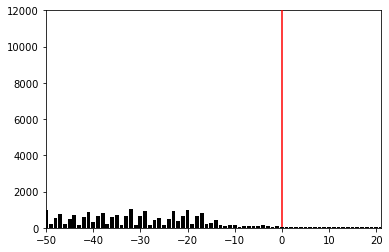

In [55]:
plt.bar(list(map(int, read_count2.index)), list(map(int, read_count2.values)), color='k', zorder=10)
plt.axvline(0, color='r', zorder=5)
plt.xlim(-50,21)
plt.ylim(0,12000)

## 4. Figure 5A (final)

In [23]:
def sam_to_df(code):
    read_table = []
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
            
            line_list = line.split()
            if line_list[1]==4 or line_list[1]==16: continue
            
            if line_list[2].startswith('ENSMUST'):
                add = line_list[2].split('|')
                read_table.append(add[:2]+[line_list[3], 1])
            
    table_df = pd.DataFrame(read_table)
    table_df.columns = ['trx','gene','pos','cnt']
    
    return table_df

In [86]:
temp = sam_to_df("RPF_siLin28a")
temp

,trx,gene,pos,cnt
0,ENSMUST00000240377.1,ENSMUSG00000119584.1,294,1
1,ENSMUST00000116560.3,ENSMUSG00000056201.9,317,1
2,ENSMUST00000209469.2,ENSMUSG00000056201.9,347,1
3,ENSMUST00000237122.2,ENSMUSG00000056201.9,237,1
4,ENSMUST00000236645.2,ENSMUSG00000056201.9,286,1
...,...,...,...,...
4792300,ENSMUST00000135312.3,ENSMUSG00000048865.17,1113,1
4792301,ENSMUST00000056449.9,ENSMUSG00000048865.17,1113,1
4792302,ENSMUST00000131607.7,ENSMUSG00000048865.17,1553,1
4792303,ENSMUST00000030547.15,ENSMUSG00000028763.19,12813,1
